In [2]:
import pandas as pd
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import numpy as np
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans
import plotly.graph_objects as go
from scipy.spatial import ConvexHull
import community.community_louvain as community_louvain
import fasttext.util
from tqdm import tqdm
from gensim.models import FastText
from gensim.test.utils import common_texts
from glove import Corpus, Glove

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Data Preparation

For non transformers embeddings we create a combined clean text. We already have clean texts from previous experiments. Also for building graph we need a dictionary which maps each company to industry.

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_parquet('/content/drive/MyDrive/comp_final_5years.parquet')

In [7]:
df_short = df[['header', 'company', 'text_clear']]

In [ ]:
df_short

header company  \
0                          Экстренная посадка в регионах    SBER   
1                          Экстренная посадка в регионах    VTBR   
2                          Экстренная посадка в регионах    AFLT   
3      "Дочка" Сбербанка назвала штраф украинского ЦБ...    SBER   
4      Газпром - Северный поток-2 заработает с 1 янва...    GAZP   
...                                                  ...     ...   
50286  🔶IR Газпром: Группа «Газпром» консолидировала ...    GAZP   
50287  ГПБ стал совладельцем завода СПГ "Газпрома" у ...    GAZP   
50288  Сооснователь Fix Price Хачатрян продал свою до...    FIXP   
50289  ЦБ РФ оценит трансграничные переводы физлиц, с...    QIWI   
50290   Сооснователь Fix Price Хачатрян продал свою долю    FIXP   

                                              text_clear  
0      итог год российский авиарынок москва январь in...  
1      итог год российский авиарынок москва январь in...  
2      итог год российский авиарынок москва январь in...  
3      украинский дочка сбербанк назвать штраф национ...  
4      глава газпром алексей миллер рассказать интерв...  
...                                                  ...  
50286  релиз группа газпром консолидировать контрольн...  
50287  группа газпромбанк стать совладелец среднетонн...  
50288  сооснователь fix price артем хачатряна выйти к...  
50289  банк россия январефеврал год провести обследов...  
50290  сооснователь fix price артем хачатряна продать...  

[50291 rows x 3 columns]

In [ ]:
aggregate_text = df_short.groupby('company')['text_clear'].apply(lambda x: " ".join(x))

In [ ]:
texts = list(aggregate_text.values)
entities = list(aggregate_text.index)

In [7]:
node_classes = {
    'MOEXOG':
    ['BANE', 'GAZP', 'LKOH', 'NVTK', 'RNFT', 'ROSN', 'SNGS', 'TATN', 'TRNF'],
    'MOEXEU': [
        'IRAO', 'HYDR', 'FEES', 'MSNG', 'UPRO', 'LSNG', 'RSTI', 'OGKB', 'MRKP',
        'MRKC', 'ELFV', 'TGKA', 'MSRS', 'MRKU', 'TGKB', 'DVEC', 'MRKZ', 'MRKV'
    ],
    'MOEXTL': ['MTSS', 'RTKM', 'MGTS', 'TTLK'],
    'MOEXMM': [
        'GMKN', 'PLZL', 'CHMF', 'NLMK', 'POLY', 'ALRS', 'MAGN', 'RUAL', 'ENPG',
        'MTLR', 'VSMO', 'SELG', 'RASP', 'SGZH', 'CHMK'
    ],
    'MOEXFN':
    ['SBER', 'TCSG', 'VTBR', 'CBOM', 'BSPB', 'QIWI', 'RENI', 'SFIN', 'AFKS'],
    'MOEXCN': [
        'MGNT', 'FIVE', 'FIXP', 'AGRO', 'GEMC', 'LENT', 'BELU', 'MDMG', 'AQUA',
        'MVID', 'APTK', 'SVAV', 'WUSH', 'ABIO', 'OKEY'
    ],
    'MOEXCH': ['PHOR', 'KAZT', 'AKRN', 'NKNC', 'KZOS'],
    'MOEXTN': ['GLTR', 'FLOT', 'AFLT', 'NMTP', 'FESH', 'NKHP', 'RKKE'],
    'MOEXIT': ['CIAN', 'HHRU', 'OZON', 'POSI', 'VKCO', 'YNDX'],
    'MOEXRE': ['ETLN', 'LSRG', 'PIKK', 'SMLT']
}

In [8]:
node_classes_new = {}
for keys,values in node_classes.items():
    for i in values:
        node_classes_new[i] = keys

In [ ]:
texts_f_ft = [text.split() for text in texts]

## TF-IDF

At first, as a baseline we create a tf-idf embedding to see if there are clusters and connections.

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)

In [ ]:
edges = []
similarity_mat = cosine_similarity(X)
for i in range(len(entities)):
    for j in range(i + 1, len(entities)):
        similarity = similarity_mat[i][j]
        if similarity > 0.7:
            edges.append((entities[i], entities[j], similarity))

We set the cutoff threshold based on the fact that the graph should display only important connections and at the same time be readable, and not just a tangle of connections. If you move the threshold higher, the number of connections with tf-idf will become too small, and if lower, too many connections will appear, so we stopped at 0.7

In [10]:
def spectral_clusterization(G, k=9):
    A = nx.adjacency_matrix(G).todense()
    D = np.diag(np.sum(A, axis=1))
    L = D - A
    D_inv_sqrt = np.linalg.inv(np.sqrt(D))
    L_norm = D_inv_sqrt @ L @ D_inv_sqrt
    eigvals, eigvecs = eigsh(L_norm, k=k, which='SM')
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(eigvecs)
    labels = kmeans.labels_
    res = {list(G.nodes)[i]: labels[i] for i in range(len(list(G.nodes)))}
    return res

In [11]:
def build_graph(edges, method, title, k=9):
    valid = ['louvin', 'spectral']
    if method not in valid:
        raise ValueError("results: status must be one of %r." % valid)

    G = nx.Graph()
    G.add_nodes_from(entities)
    G.add_weighted_edges_from(edges)
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)

    node_classes = node_classes_new

    class_colors = {
        'MOEXOG': 'rgba(51,51,51,1)',
        'MOEXEU': 'rgba(255,255,0,1)',
        'MOEXTL': 'rgba(102,0,153,1)',
        'MOEXMM': 'rgba(204,204,204,1)',
        'MOEXFN': 'rgba(0,153,0,1)',
        'MOEXCN': 'rgba(204,0,0,1)',
        'MOEXCH': 'rgba(204,255,0,1)',
        'MOEXTN': 'rgba(0,153,255,1)',
        'MOEXIT': 'rgba(0,51,204,1)',
        'MOEXRE': 'rgba(102,51,0,1)'
    }
    if method == 'louvin':
        partition = community_louvain.best_partition(G.to_undirected())
    else:
        partition = spectral_clusterization(G, k)

    pos = nx.kamada_kawai_layout(G)

    edge_x = []
    edge_y = []
    weights = []
    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        weights.append(edge[2]['weight'])

    weights = np.array(weights)
    norm_weights = (weights - weights.min()) / (weights.max() - weights.min())

    fig = go.Figure()

    for i in range(len(edge_x)//3):
        fig.add_trace(go.Scatter(
            x=edge_x[i*3:(i+1)*3],
            y=edge_y[i*3:(i+1)*3],
            line=dict(width=2, color=f'rgba(0,0,255,{norm_weights[i]})'),
            hoverinfo='none',
            mode='lines',
            showlegend=False
        ))

    clusters = list(set(partition.values()))
    cluster_colors = {cluster: f'rgba({np.random.randint(0, 255)}, {np.random.randint(0, 255)}, {np.random.randint(0, 255)}, 0.3)' for cluster in clusters}

    for cluster in clusters:
        cluster_nodes = [node for node in G.nodes if partition[node] == cluster]
        if len(cluster_nodes) > 2:
            cluster_pos = np.array([pos[node] for node in cluster_nodes])
            hull = ConvexHull(cluster_pos)
            hull_pts = cluster_pos[hull.vertices]
            hull_x = hull_pts[:, 0]
            hull_y = hull_pts[:, 1]
            fig.add_trace(go.Scatter(
                x=hull_x.tolist() + [hull_x[0]],
                y=hull_y.tolist() + [hull_y[0]],
                fill='toself',
                fillcolor=cluster_colors[cluster],
                line=dict(color='rgba(255,255,255,0)'),
                hoverinfo='none',
                mode='lines',
                showlegend=False
            ))

    node_x = []
    node_y = []
    node_sizes = []
    node_colors = []
    node_texts = []
    for node in pos:
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_sizes.append(10 + (G.degree(node)))
        node_colors.append(class_colors[node_classes[node]])
        node_texts.append(f'Node {node}: Degree {G.degree(node)}, Class {node_classes[node]}')

    fig.add_trace(go.Scatter(
        x=node_x,
        y=node_y,
        mode='markers+text',
        text=[f'{node}' for node in G.nodes],
        textposition='top center',
        marker=dict(size=node_sizes, color=node_colors),
        hoverinfo='text',
        name='Nodes',
        showlegend=False
    ))

    for node_class, color in class_colors.items():
        fig.add_trace(go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(size=10, color=color),
            legendgroup=node_class,
            showlegend=True,
            name=f'{node_class}'
        ))

    colorbar_trace = go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(
            size=10,
            color=[weights.min(), weights.max()],
            colorscale=[f'rgba(0,0,255,{sorted(norm_weights)[i]})' for i in range(len(edge_x)//3)],
            colorbar=dict(
                title='Cosine Similarity',
                titleside="right",
                tickvals=[weights.min(), weights.max()],
                ticktext=[round(weights.min(), 3), round(weights.max(), 3)],
                orientation='h',
                x=0.5,
                xanchor='center',
                y=-0.1,
                yanchor='top'
            )
        ),
        showlegend=False,
        hoverinfo='none'
    )

    fig.add_trace(colorbar_trace)
    fig.update_layout(showlegend=True, autosize=False, width=1200, height=750, title_text=title, legend_title_text='Industrial Indexes')
    fig.show(renderer='png')


We will perform both Spectral Clusterization and Louvin Method. Spectral Clusterization is suitable for mid sized datasets and can find deep insights, but it requires us to set number of clusters. So we'll go by cluster size from 5 to 11 in 2 steps to identify the most realistic and explicable clusters.

Louvin Method is a technique for searching communities in graphs based on modularity (metric which measures the quality of a division into communities)

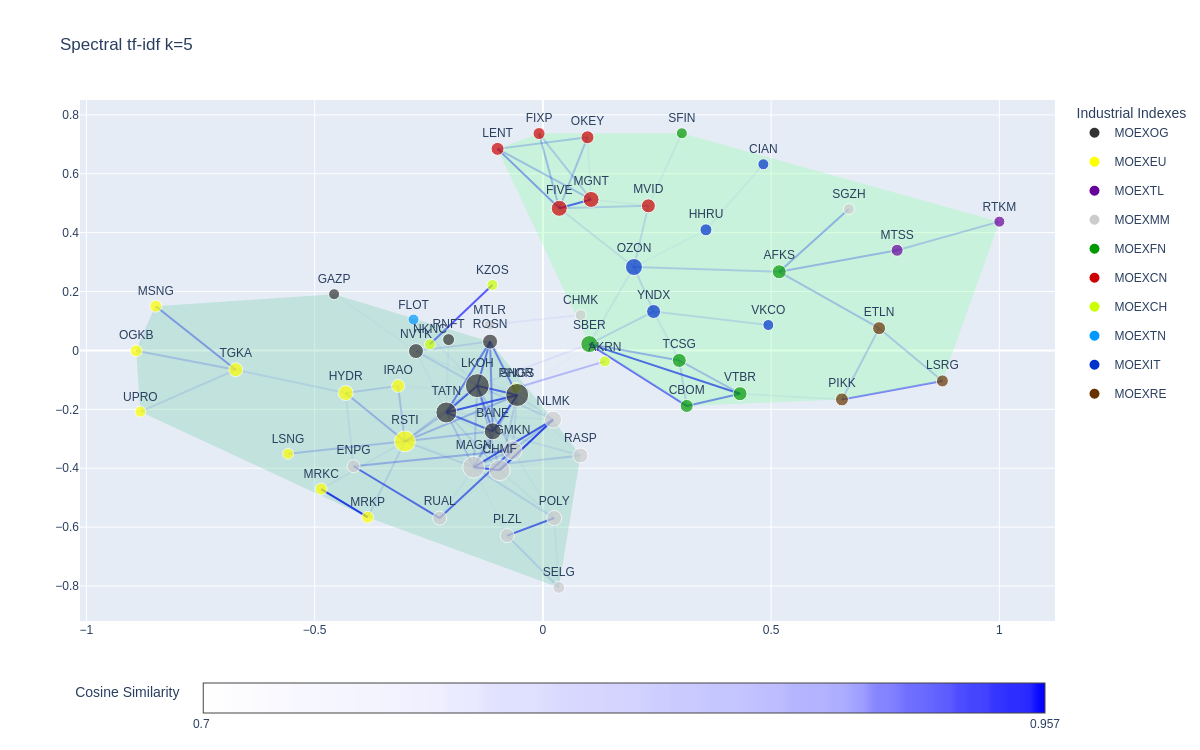

In [ ]:
build_graph(edges, method='spectral', k=5, title='Spectral tf-idf k=5')

> Too large clusters, however it is clearly seen that there is a difference between consumer oriented companies and manufacturing companies.

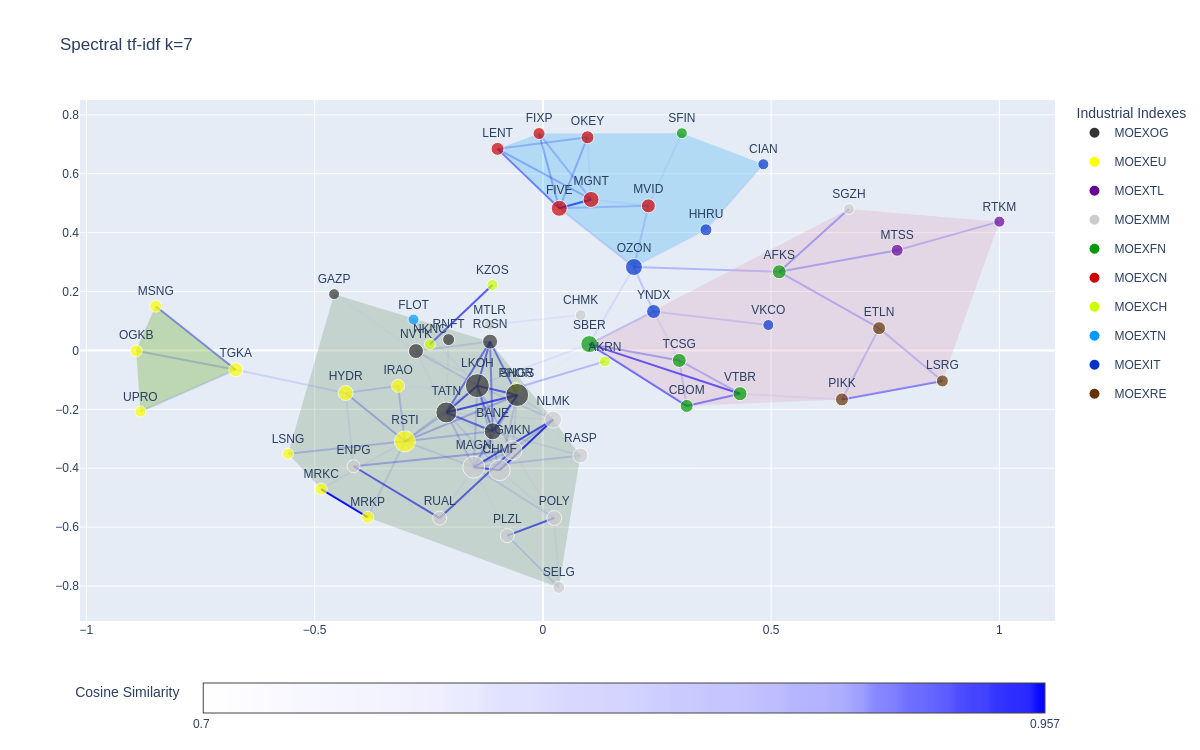

In [ ]:
build_graph(edges, method='spectral', k=7, title='Spectral tf-idf k=7')

> Still one cluster for almost all manufacturing and electroenergy companies. There appears a difference between 2 groups of consumers oriented companies.

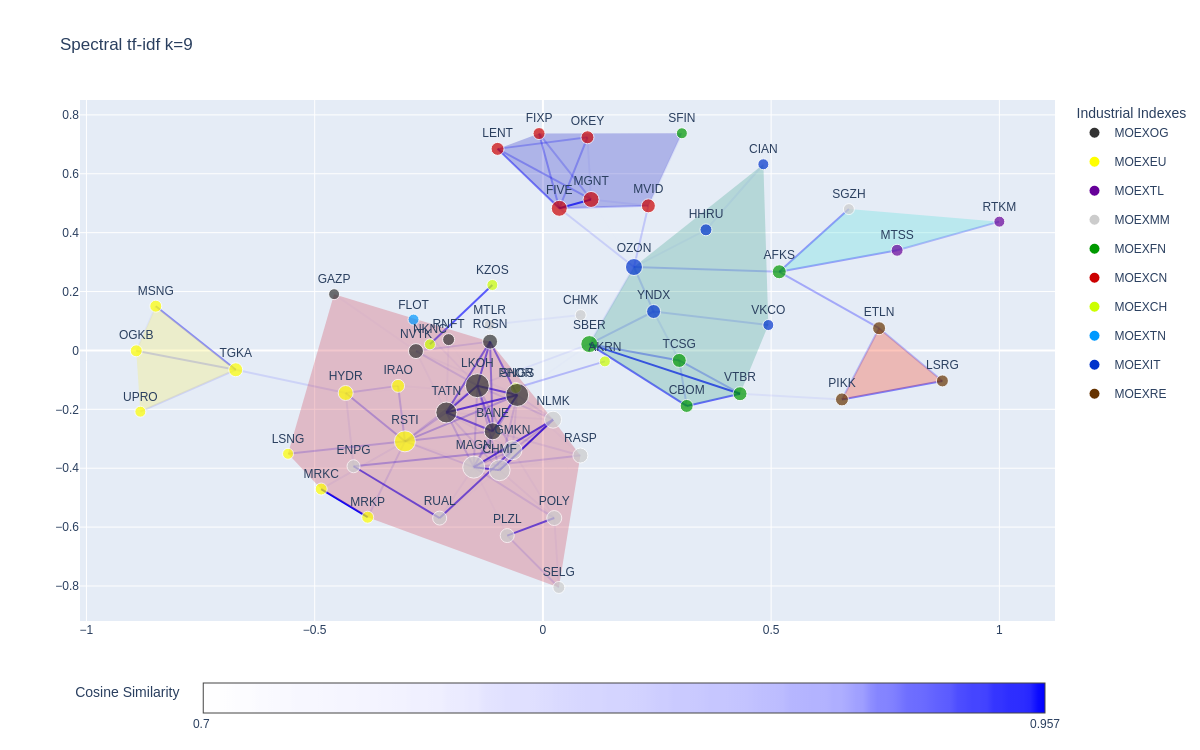

In [ ]:
build_graph(edges, method='spectral', k=9, title='Spectral tf-idf k=9')

> Manufacturing side still holds together while consumer oriented side splits into different clusters, which can be explainable from the perspective of ownership, business profile and etc.

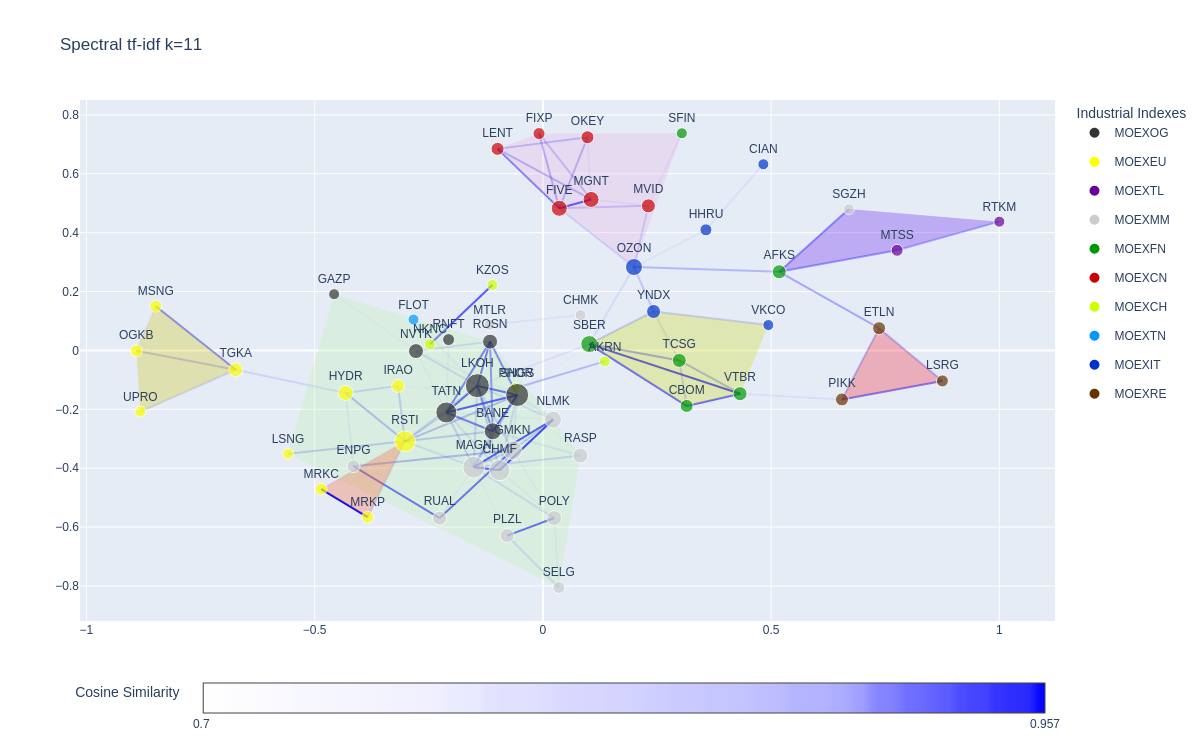

In [ ]:
build_graph(edges, method='spectral', k=11, title='Spectral tf-idf k=11')

> No improvement, only own clusters of CIAN and HHRU appear

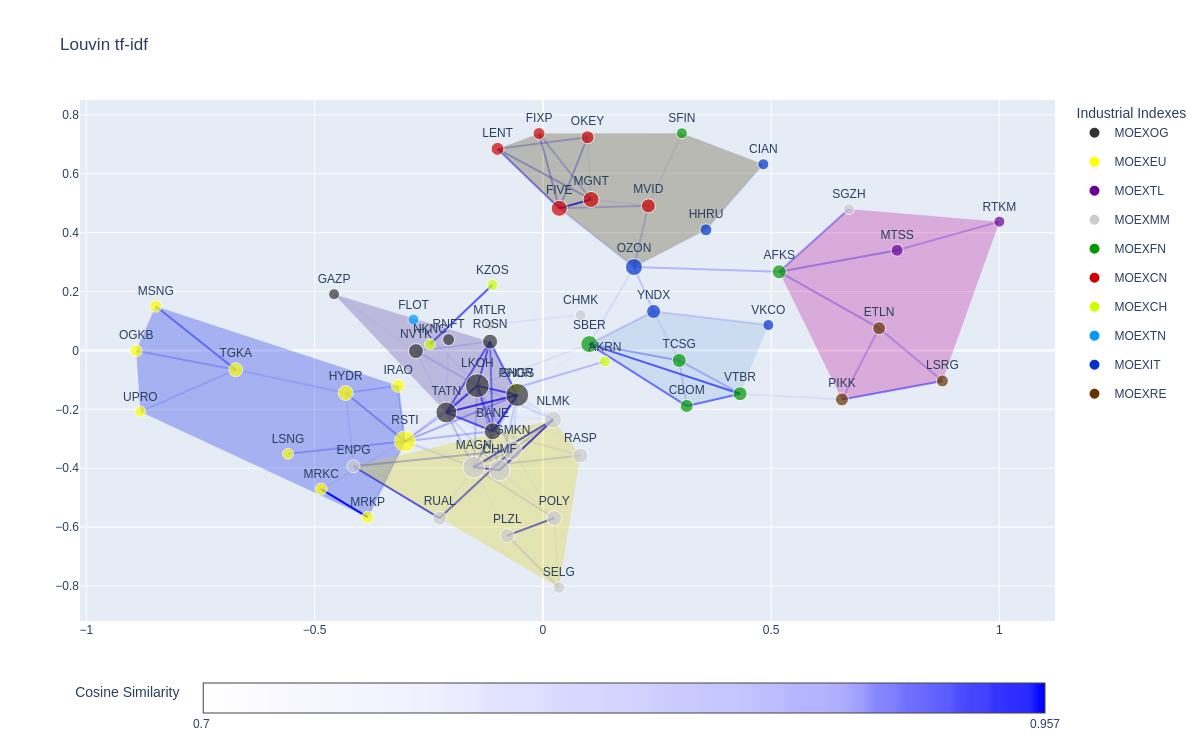

In [ ]:
build_graph(edges, method='louvin', title='Louvin tf-idf')

> Louvin looks different as it splits manufacturers and electoenergy companies. Clusterization of consumer oriented compnies also looks a little different. Real estate companies somehow occured in same cluster as telecom.

> Tf-idf based graphs appear to be rather good, as there is a clear explanation behind each edge. These graphs allows us to split companies into several clusters in a way that make sense. It is a good baseline, based on every word in our corpus.

## Fasttext

The second embedding we use is pre-trained FastText. It is a popular embeddings generation technique that allows to capture oov words, which may help to find some missing information.

In [ ]:
fasttext.util.download_model('ru', if_exists='ignore')
ft = fasttext.load_model('cc.ru.300.bin')

In [ ]:
def get_text_embeddings(text):

    embeddings = [ft.get_word_vector(word) for word in text]
    return sum(embeddings) / len(embeddings)

In [ ]:
X_emb = []

In [ ]:
for text in tqdm(texts):
    text_embedding = get_text_embeddings(text.split())
    X_emb.append(text_embedding)

100%|██████████| 91/91 [02:41<00:00,  1.77s/it]


In [ ]:
X_emb = np.load('embeddings.npy')

In [ ]:
edges = []
similarity_mat = cosine_similarity(X_emb)
for i in range(len(entities)):
    for j in range(i + 1, len(entities)):
        similarity = similarity_mat[i][j]
        if similarity > 0.99:
            edges.append((entities[i], entities[j], similarity))

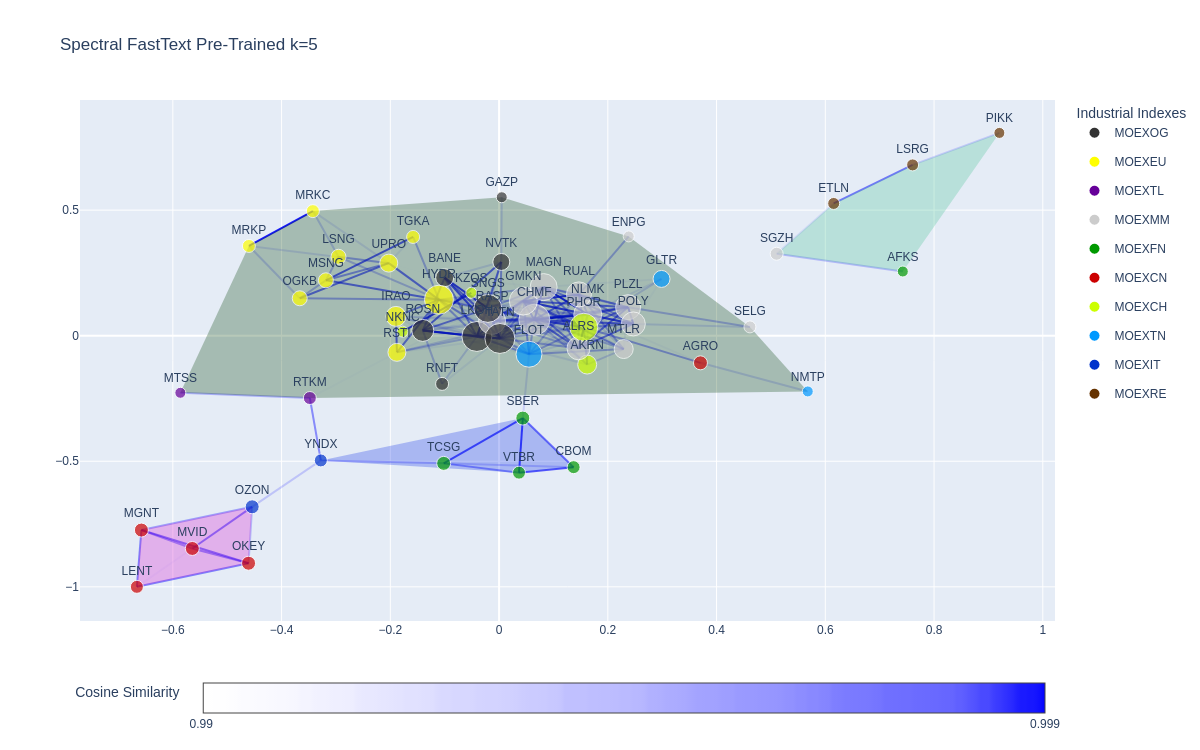

In [ ]:
build_graph(edges, method='spectral', k=5, title='Spectral FastText Pre-Trained k=5')

> Too bad, almost everything is concentrated in same area, one cluster is too large. However, we can see consumers products, banks and real estate companies are concentrated in other areas, which makes sense.

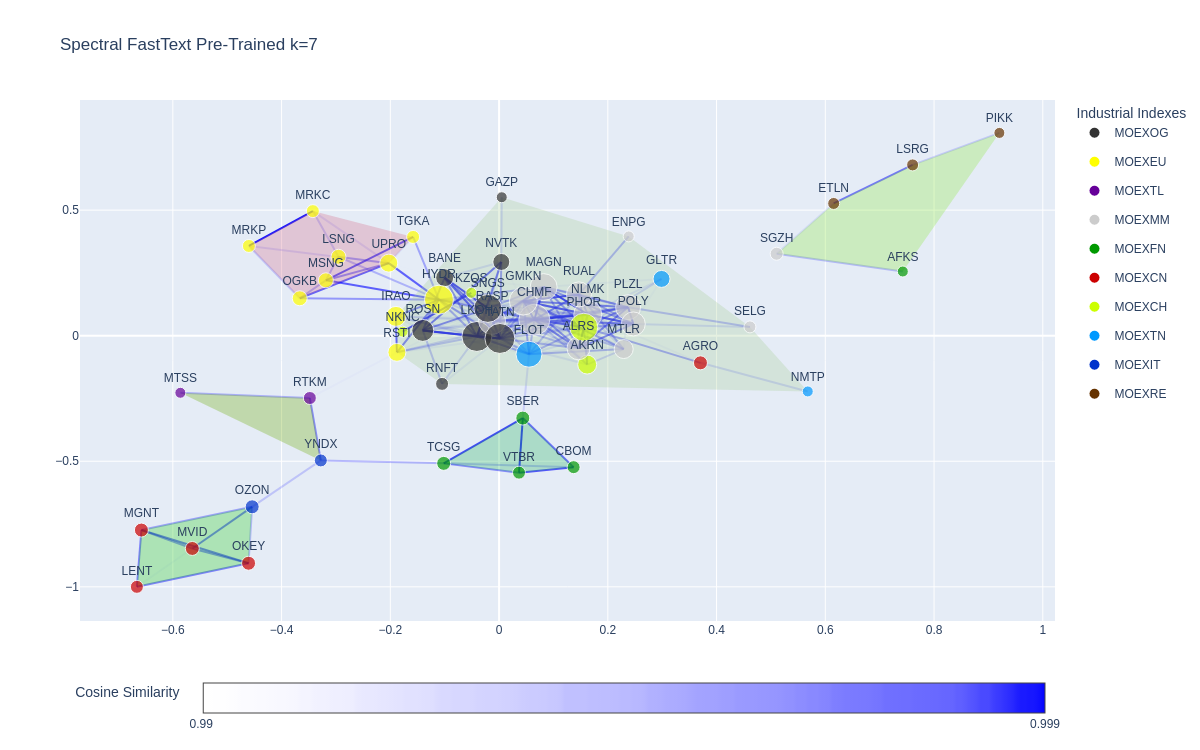

In [ ]:
build_graph(edges, method='spectral', k=7, title='Spectral FastText Pre-Trained k=7')

> Now energy cluster is seen, but still too much companies in 1 cluster

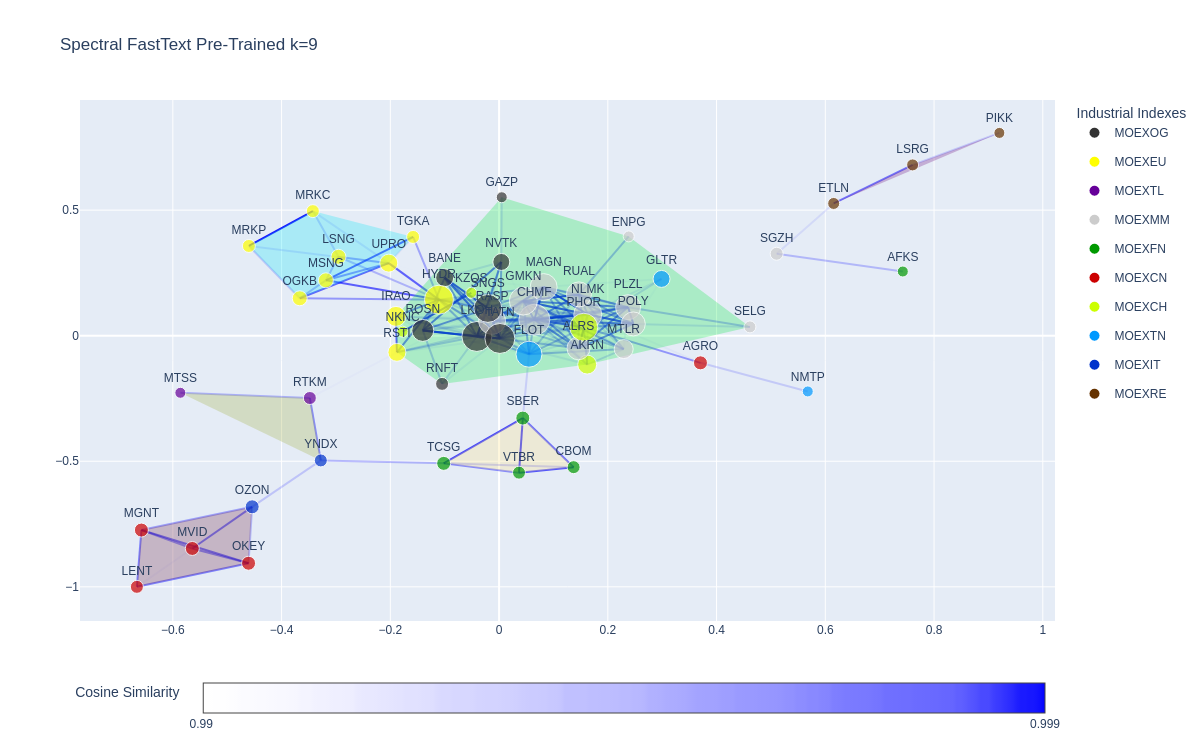

In [ ]:
build_graph(edges, method='spectral', k=9, title='Spectral FastText Pre-Trained k=9')

> It becomes worse as real estate companies represent their own cluster

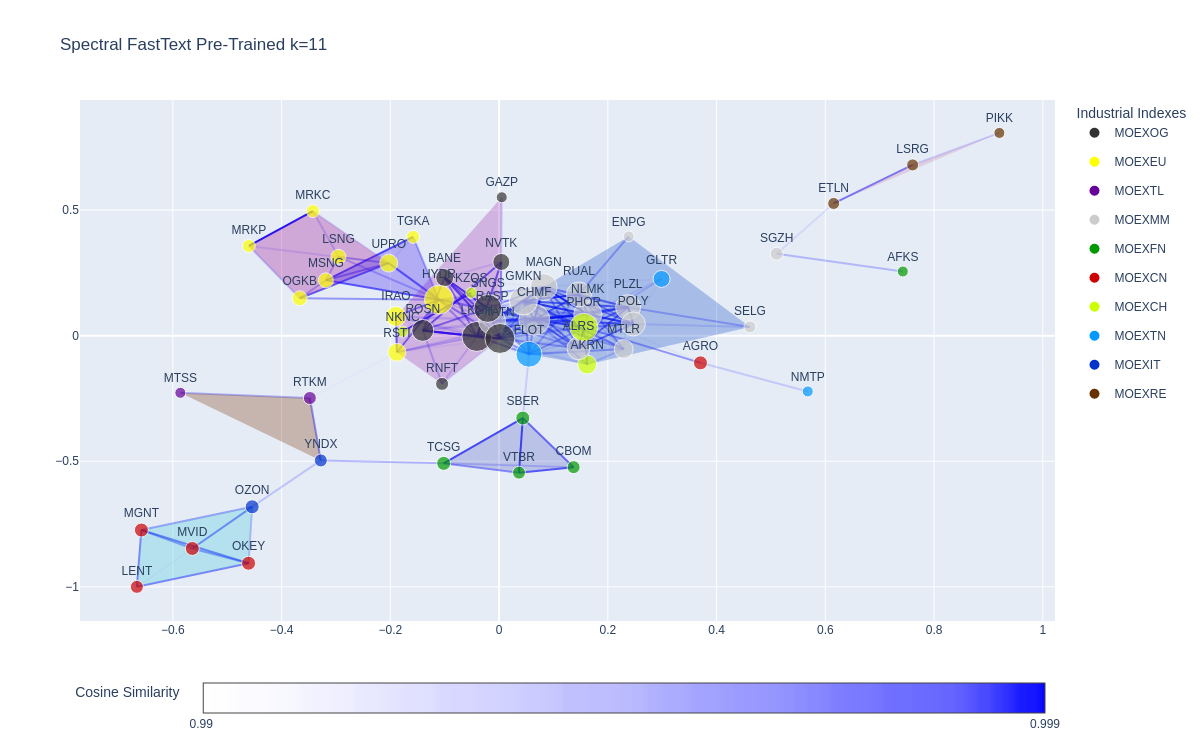

In [ ]:
build_graph(edges, method='spectral', k=11, title='Spectral FastText Pre-Trained k=11')

> Looks better, manufacturers are splitted into oil and metal companies

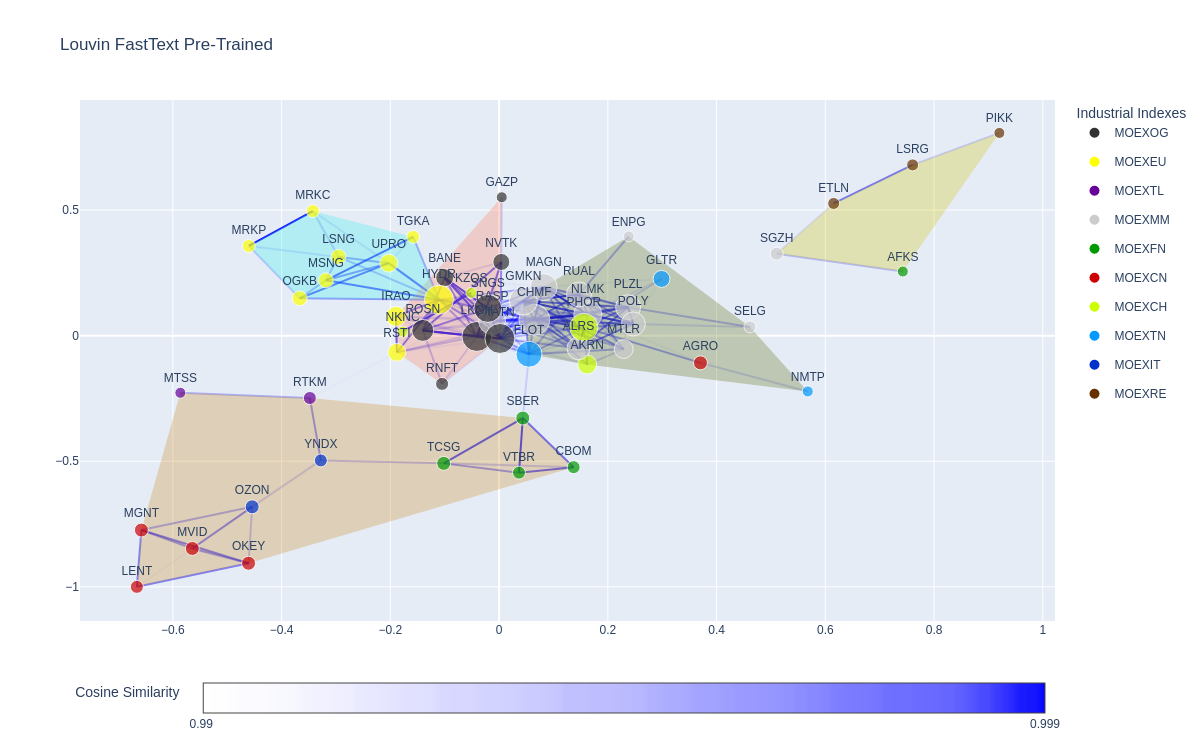

In [ ]:
build_graph(edges, method='louvin', title='Louvin FastText Pre-Trained')

> Clustering is quite similar to spectral clustering, but the consumer sector is too large, in the spectral version it is divided into smaller clusters.

> FastText pre-trained embeddings wasn't really helpful as cosine similarity between embeddings is too large and there are a lot of closely related companies in this case. However, it didn't catch some of connections, which tf-idf did (like ownership of MTSS by AFKS), which resulted in their separation. It is not helpful in determination of market effect of possible connections.

In [ ]:
np.save('sim_matrix', similarity_mat)

In [ ]:
np.save('embeddings', np.array(X_emb))

### FastText learn

Now let's try to train FastText on our corpus, maybe it will help to capture the missing connections, which are underseen by pre-trained model.

In [ ]:
model = FastText(sentences=texts_f_ft, vector_size=300, window=5, min_count=1, workers=4, sg=1)

In [ ]:
def get_text_embeddings(text):

    embeddings = [model.wv[word] for word in text]
    return sum(embeddings) / len(embeddings)

In [ ]:
X_emb_2 = []

In [ ]:
for text in tqdm(texts):
    text_embedding = get_text_embeddings(text.split())
    X_emb_2.append(text_embedding)

100%|██████████| 91/91 [00:35<00:00,  2.55it/s]


In [ ]:
edges = []
similarity_mat = cosine_similarity(X_emb_2)
for i in range(len(entities)):
    for j in range(i + 1, len(entities)):
        similarity = similarity_mat[i][j]
        if similarity > 0.998:
            edges.append((entities[i], entities[j], similarity))

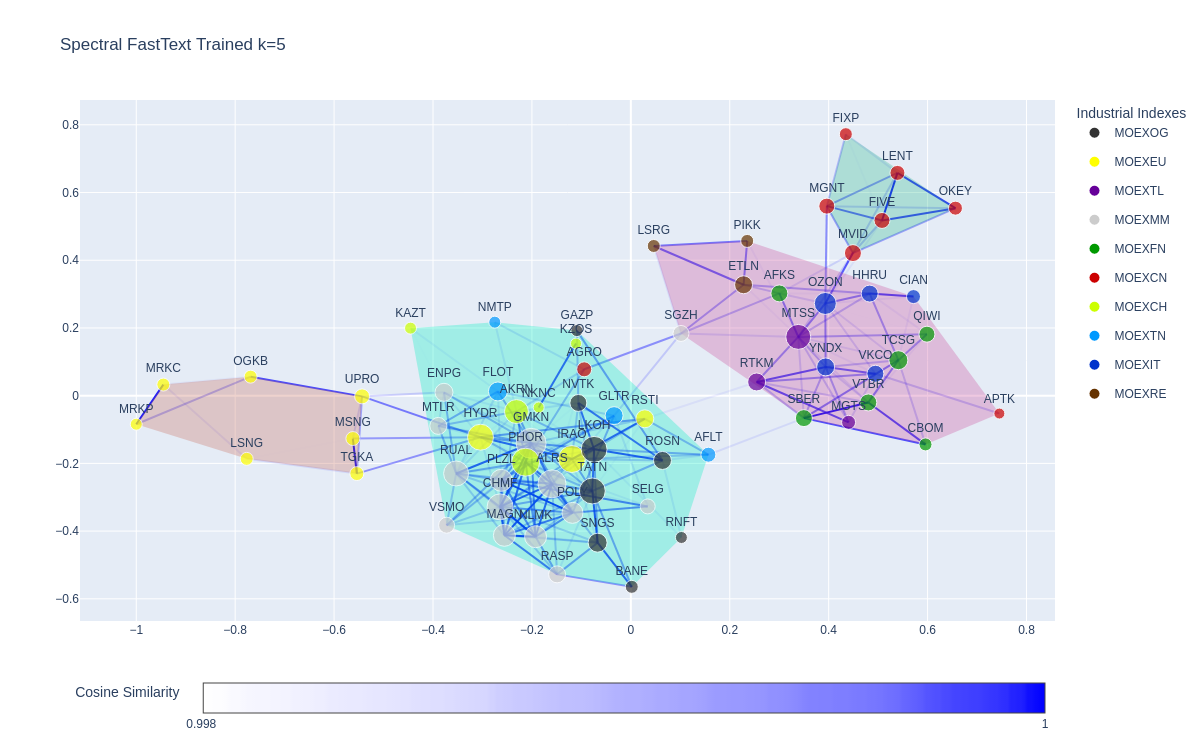

In [ ]:
build_graph(edges, method='spectral', k=5, title='Spectral FastText Trained k=5')

> 4 large clusters can be clearly seen. But they are still too big

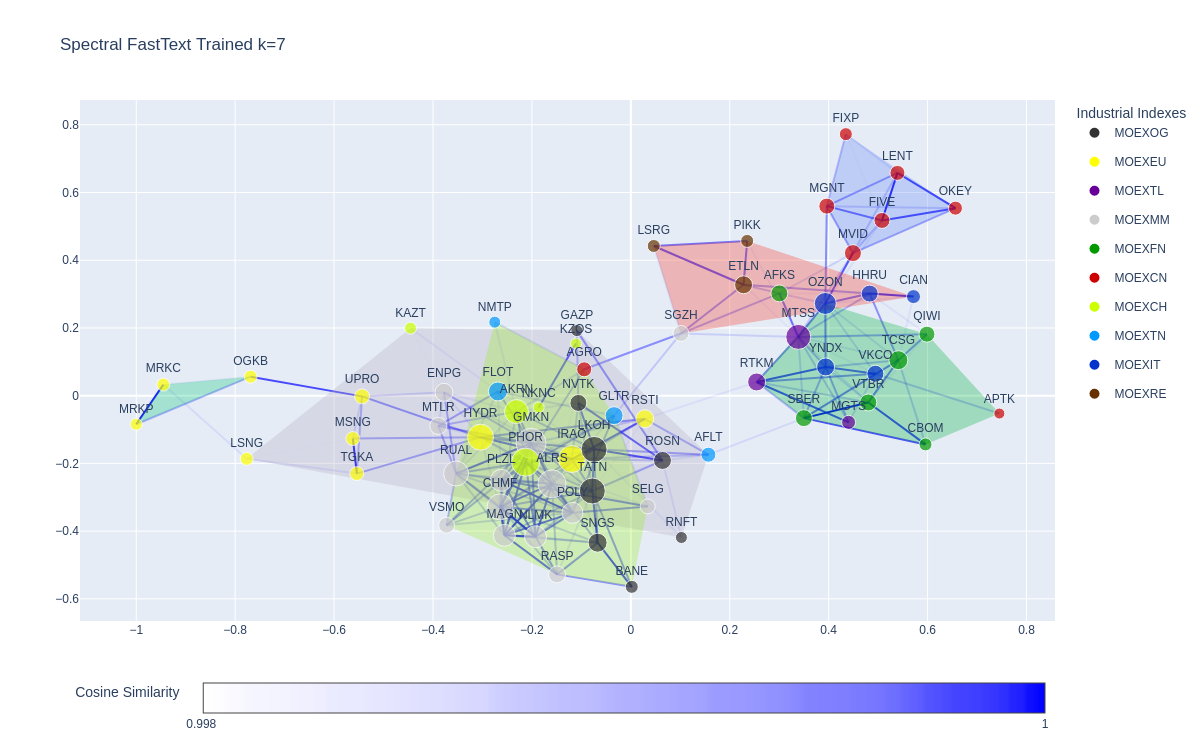

In [ ]:
build_graph(edges, method='spectral', k=7, title='Spectral FastText Trained k=7')

> Real estate companies now have their cluster. Largest cluster splitted in 2, but they overlap. The possible reasoning behind this division is not clear.

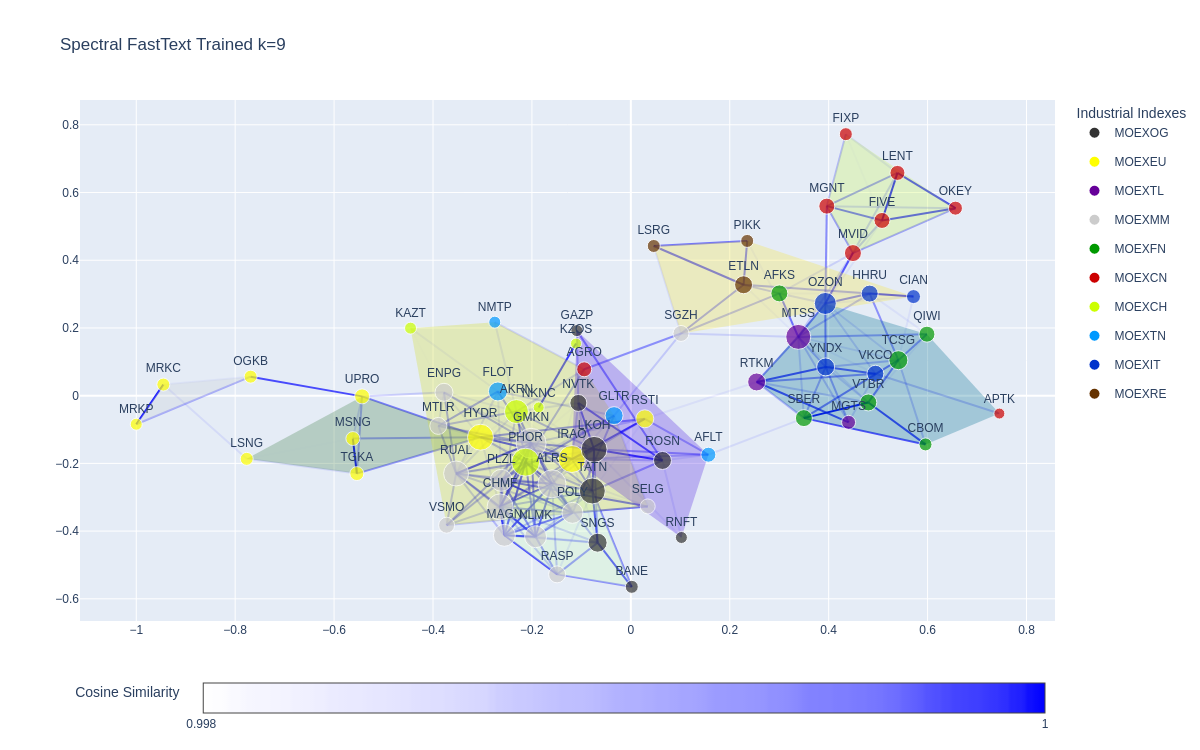

In [ ]:
build_graph(edges, method='spectral', k=9, title='Spectral FastText Trained k=9')

> It looks much more strange. The principles of clustering are not clear, and the principles by which they intersect are also

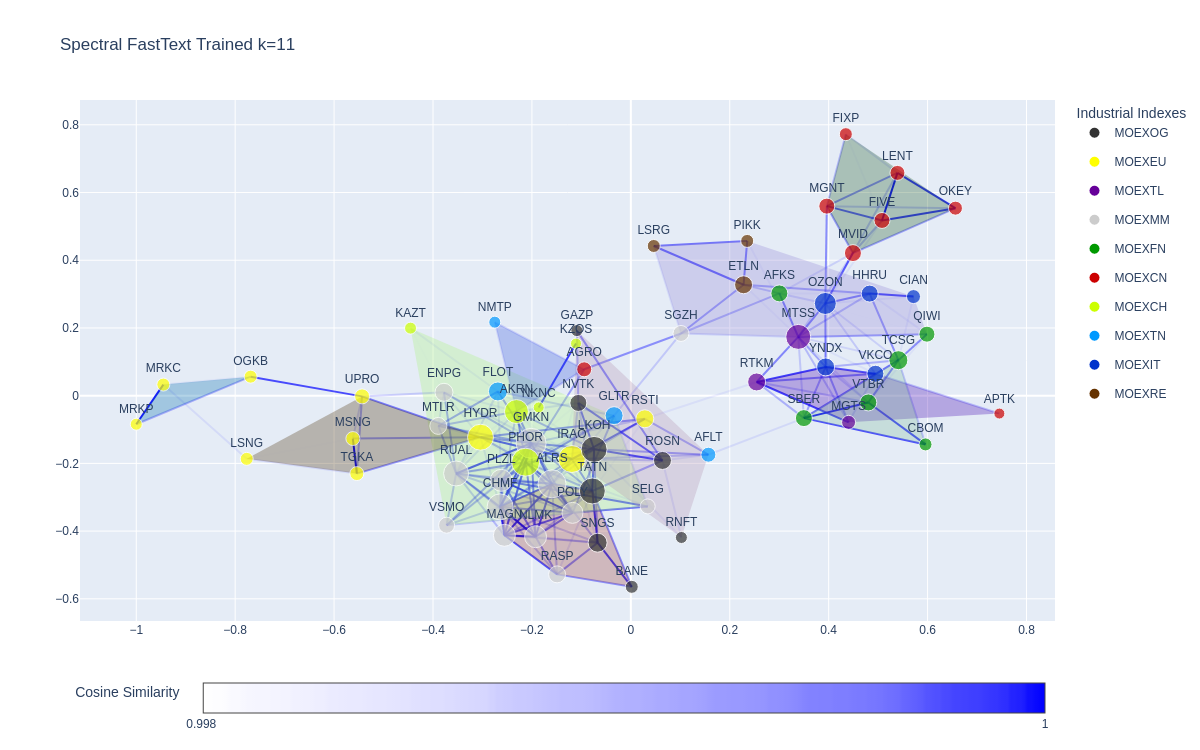

In [ ]:
build_graph(edges, method='spectral', k=11, title='Spectral FastText Trained k=11')

> There is a feeling that there are too many clusters, their intersections are even more unclear

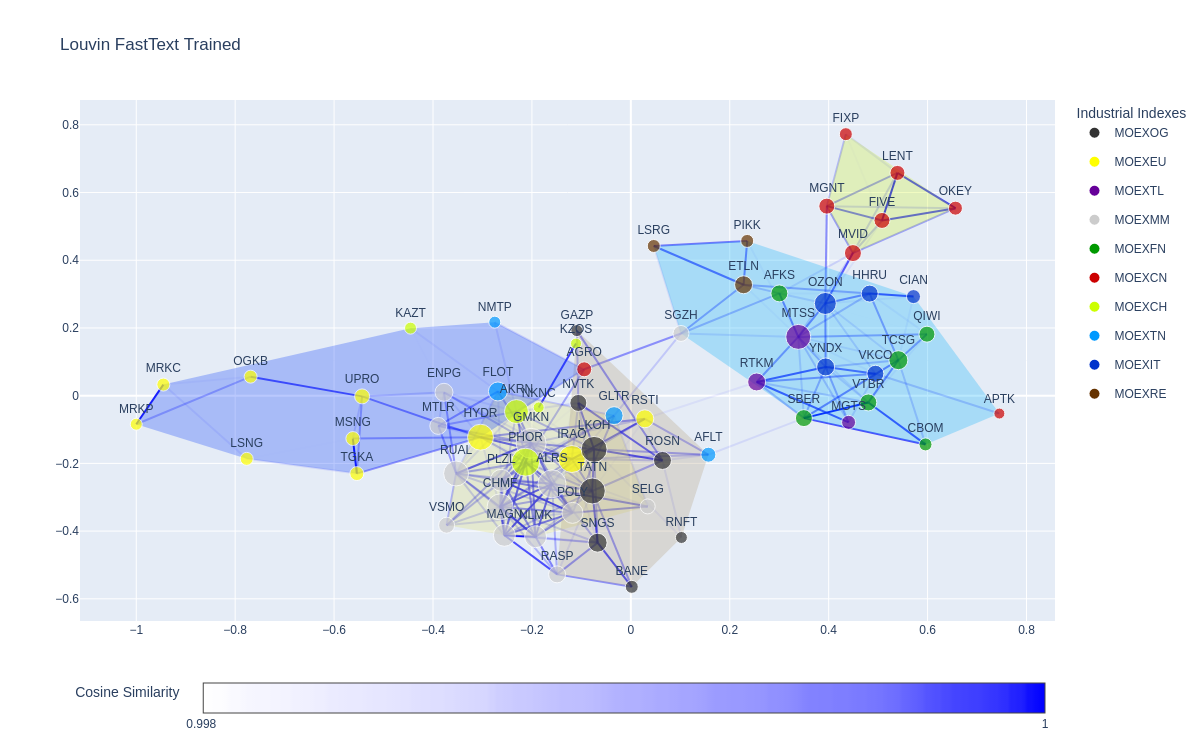

In [ ]:
build_graph(edges, method='louvin', title='Louvin FastText Trained')

> There are also non-obvious clusters, it does not seem that they are meaningful

> Trained FastText performed even worse, embeddings are very similar to one another. Probably, FastText is not suitable for large texts. However, it still captures a lot of connections, it's just you can't distinguish between them.

## Glove learn

GloVe allows us to incorporate global context of texts. It can be pretty helpful in terms of financial news. However, we believe that we should learn based on our corpus to achieve better result, because common expressions can have a completely different meaning in a financial context.

In [ ]:
from glove import Corpus, Glove

In [ ]:
corpus = Corpus()

corpus.fit(texts_f_ft, window=10)

glove = Glove(no_components=300, learning_rate=0.05)
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

In [ ]:
def get_text_embeddings(text):
    embeddings = [glove.word_vectors[glove.dictionary[word]] for word in text]
    return sum(embeddings) / len(embeddings)

In [ ]:
X_emb_3 = []

In [ ]:
for text in tqdm(texts):
    text_embedding = get_text_embeddings(text.split())
    X_emb_3.append(text_embedding)

100%|██████████| 91/91 [00:21<00:00,  4.27it/s]


In [ ]:
edges = []
similarity_mat = cosine_similarity(X_emb_3)
for i in range(len(entities)):
    for j in range(i + 1, len(entities)):
        similarity = similarity_mat[i][j]
        if similarity > 0.985:
            edges.append((entities[i], entities[j], similarity))

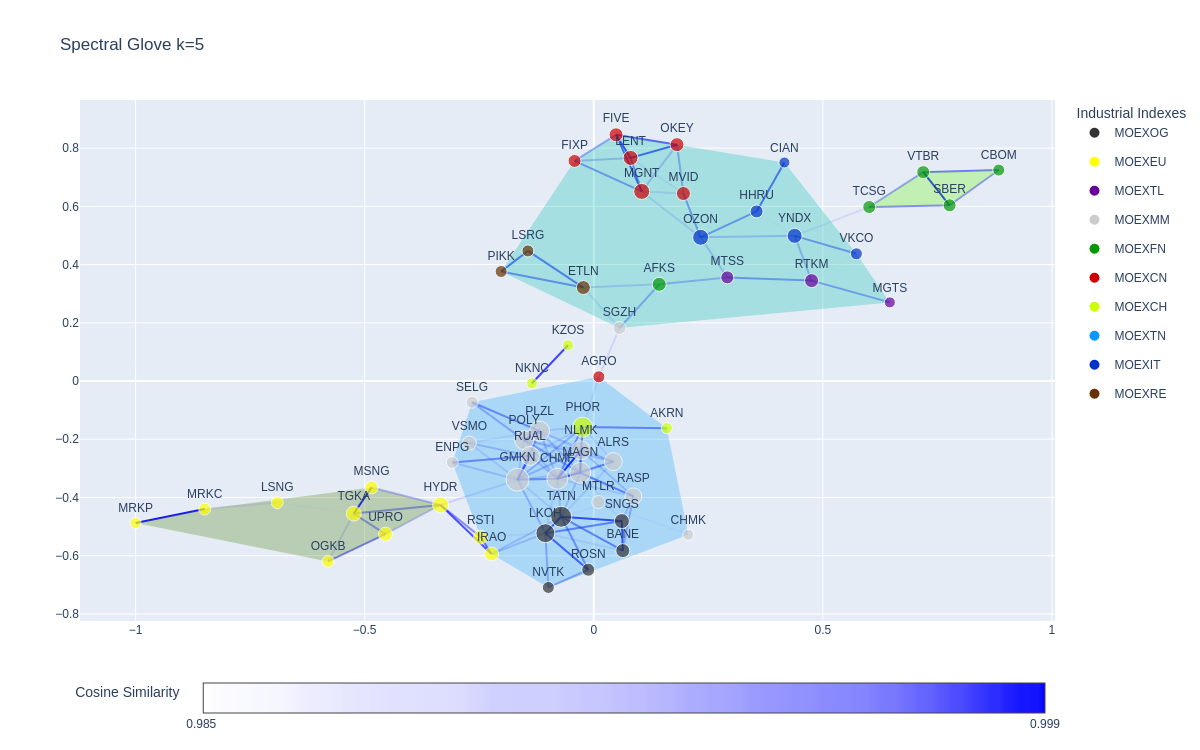

In [ ]:
build_graph(edges, method='spectral', k=5, title='Spectral Glove k=5')

> As before, with a small k, the clusters are too large. Although in this case they look more or less meaningful

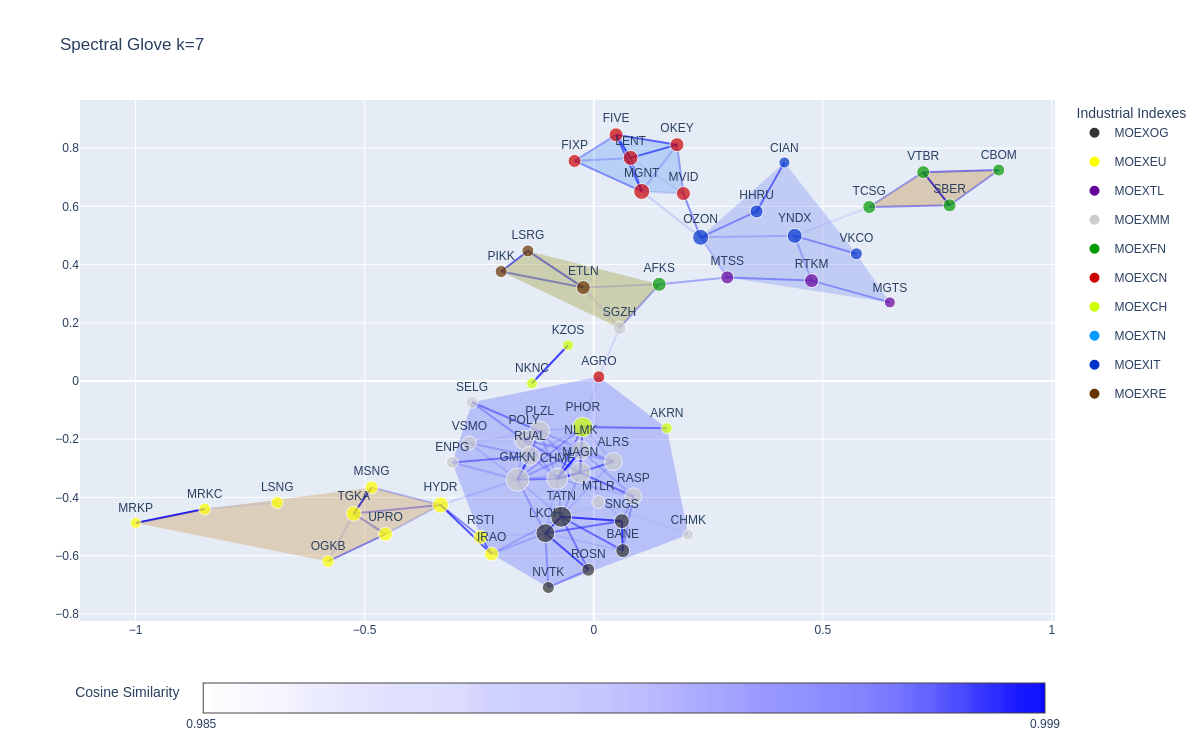

In [ ]:
build_graph(edges, method='spectral', k=7, title='Spectral Glove k=7')

> It is better, now banks have their own cluster, real estate companies are in one cluster, as well as telecom and it. Still, the largest cluster is still too large.

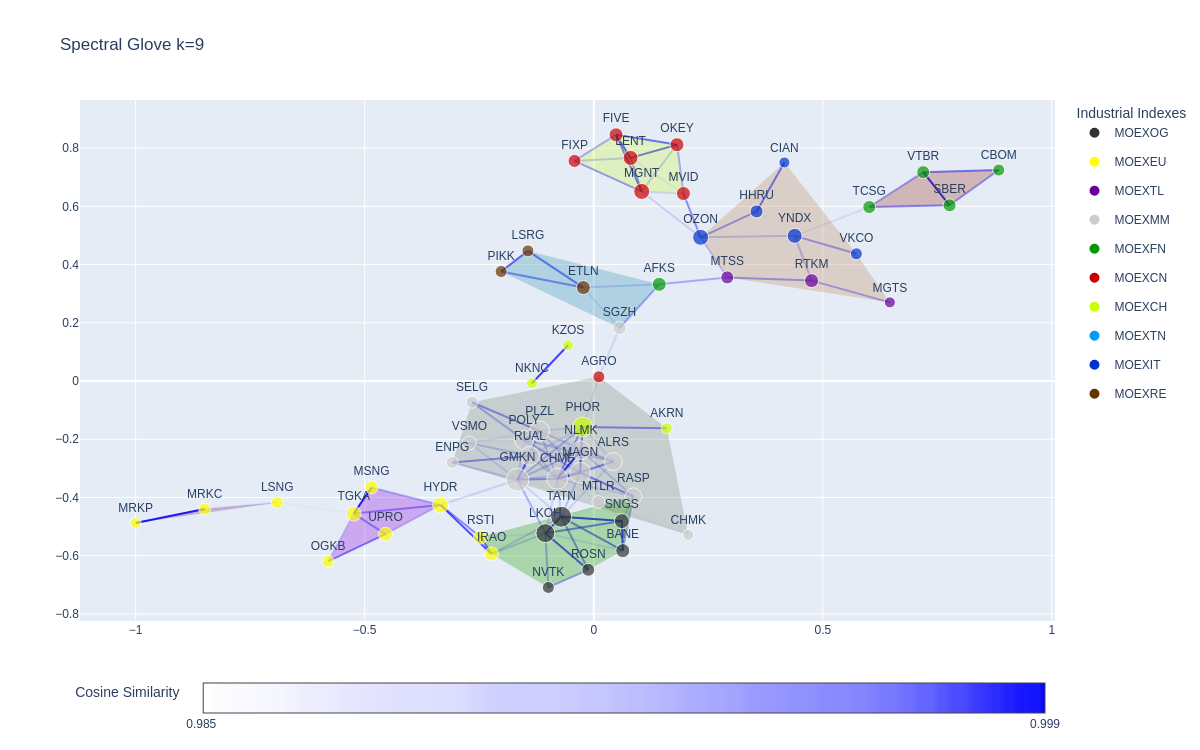

In [ ]:
build_graph(edges, method='spectral', k=9, title='Spectral Glove k=9')

> It looks better than the previous one. Even metals and oil stood out separately. The only thing that is a little frustrating is the electric power industry

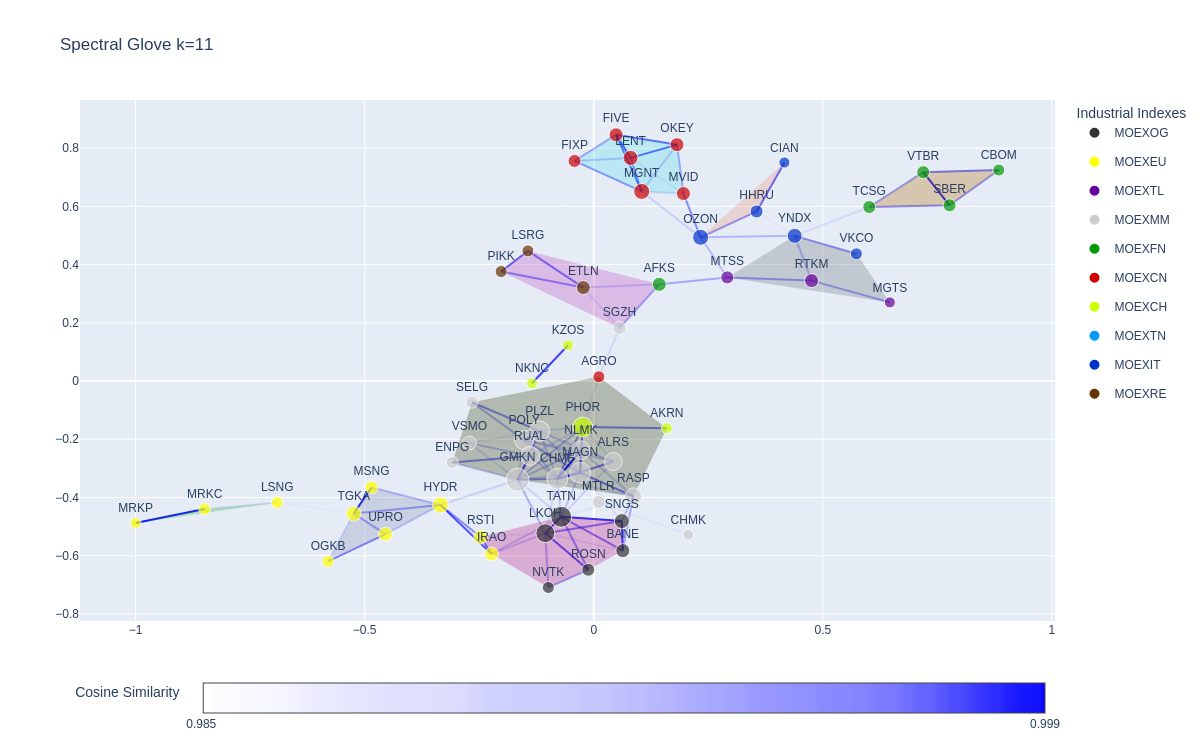

In [ ]:
build_graph(edges, method='spectral', k=11, title='Spectral Glove k=11')

> Looks worse than previous, too many clusters

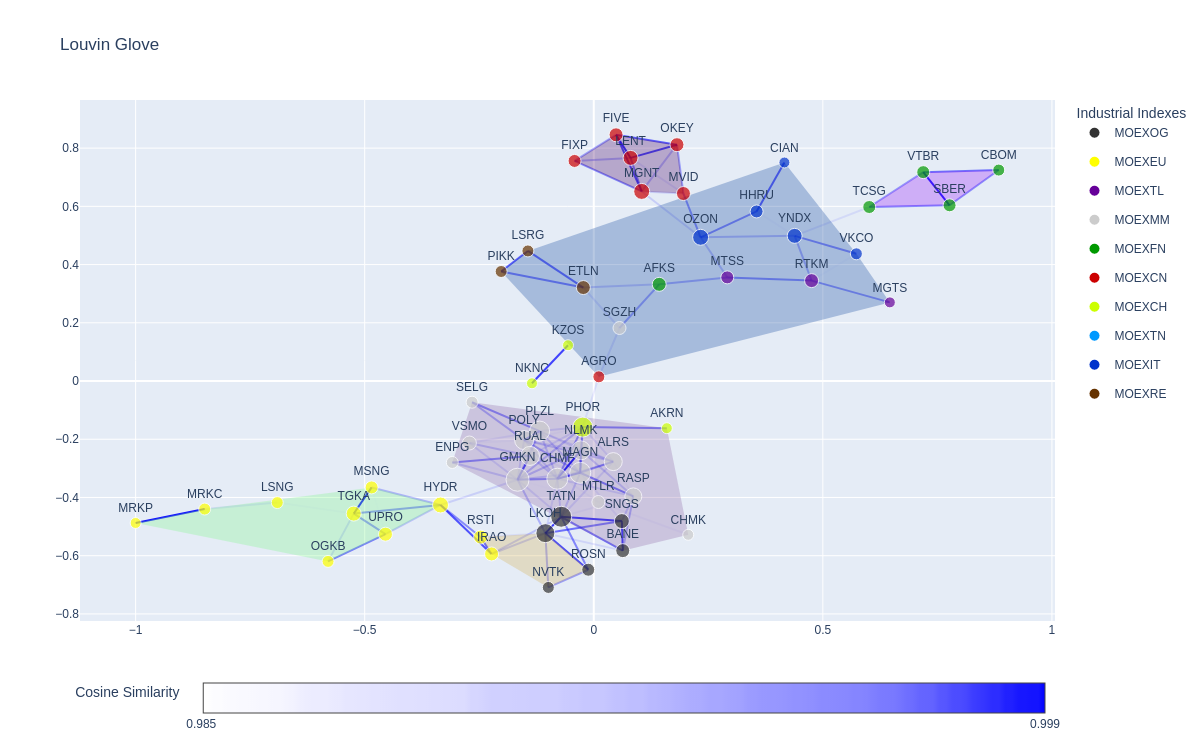

In [ ]:
build_graph(edges, method='louvin', title='Louvin Glove')

> Very similar to the best of spectral clustering. It seems that some borderline cases are different.

> GloVe made it possible to draw a much more separable graph, so that clusters stand out very well, and they can be explained both in the case of spectral clustering and using the Louvin method. Spectral clustering with 9 clusters seems the most reasonable clusterization in terms of explainability, visual clearliness.

In [ ]:
np.save('embeddings_glove', np.array(X_emb_3))

Now we will try to surpass the previous result by increasing the embedding length to keep more information. We will see for same numbers of clusters as in the best example from above (9).

In [ ]:
corpus = Corpus()

corpus.fit(texts_f_ft, window=10)

glove = Glove(no_components=600, learning_rate=0.05)
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

In [ ]:
X_emb_4 = []

In [ ]:
for text in tqdm(texts):
    text_embedding = get_text_embeddings(text.split())
    X_emb_4.append(text_embedding)

100%|██████████| 91/91 [00:37<00:00,  2.45it/s]


In [ ]:
edges = []
similarity_mat = cosine_similarity(X_emb_4)
for i in range(len(entities)):
    for j in range(i + 1, len(entities)):
        similarity = similarity_mat[i][j]
        if similarity > 0.985:
            edges.append((entities[i], entities[j], similarity))

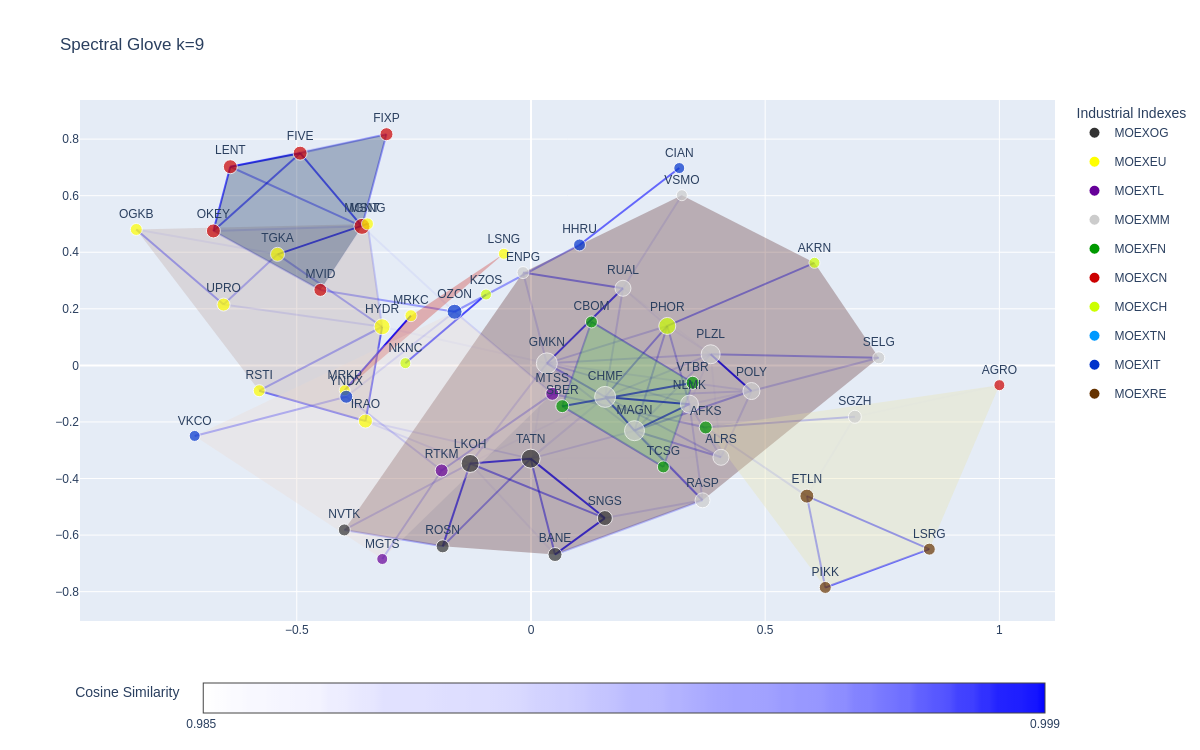

In [ ]:
build_graph(edges, method='spectral', k=9, title='Spectral Glove k=9')

> Visually it's a mess as well as in terms of explainability.

# Results



>1.   We generated embeddings of news texts using tf-idf, FastText and GloVe, and based on the cosine distance between the company texts, we built a graph describing possible connections and clusters. For FastText and GloVe we generated embeddings of shape 300.
>2.  In our opinion, the graph generated on the basis of GloVe embeddings turned out to be the best graph, since there are reasonable connections on it, there are not too many of them, you can sort them out and differentiate them by strength.
>3.   Spectral clustering and the Louvin method were used to determine clusters. It seems that the clusters identified by spectral clustering with 9 clusters turned out to be the most understandable and explicable.

